# Importing the dependencies

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import category_encoders as ce
from scipy.stats import skew,yeojohnson,boxcox
from sklearn.preprocessing import OrdinalEncoder
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler

# Importing the models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import accuracy_score
import optuna
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Everything imported succesfully")

Everything imported succesfully


In [5]:
import sklearn
print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.4.1.post1


In [6]:
# Loading training data
df = pd.read_csv('../Model Building/loan-train.csv')
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].astype(object)
df.head(4)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y


In [7]:
# Replacing Yes with 1 and No with 0
df['Loan_Status'] = df['Loan_Status'].replace('Y',1)
df['Loan_Status'] = df['Loan_Status'].replace('N',0)

C:\Users\ropar_i9941t3\AppData\Local\Temp\ipykernel_10064\3066077728.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Loan_Status'] = df['Loan_Status'].replace('N',0)


# Defining the utility function

In [8]:
# Finding the upper and lower limit
def find_limits(column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3-q1
    Upper_lmt = q3 + 1.5*IQR
    Lower_lmt = q1 - 1.5*IQR
    return [Upper_lmt,Lower_lmt]

In [9]:
# Removing unnecessary attribue
df.drop(['Loan_ID'],axis=1,inplace=True)

# Exploratory data analysis

In [10]:
# Shape of the dataframe
df.shape

(614, 12)

In [11]:
# Getting feature information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    object 
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 57.7+ KB


In [12]:
# Removing duplicate values if they exist
duplicate_values = df.duplicated().sum()
if duplicate_values > 0:
    print("Total "+ str() + " duplicate values removed")
    df.drop_duplicated(inplace=True)
else:
    print("There are no duplicate values")

There are no duplicate values


Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64


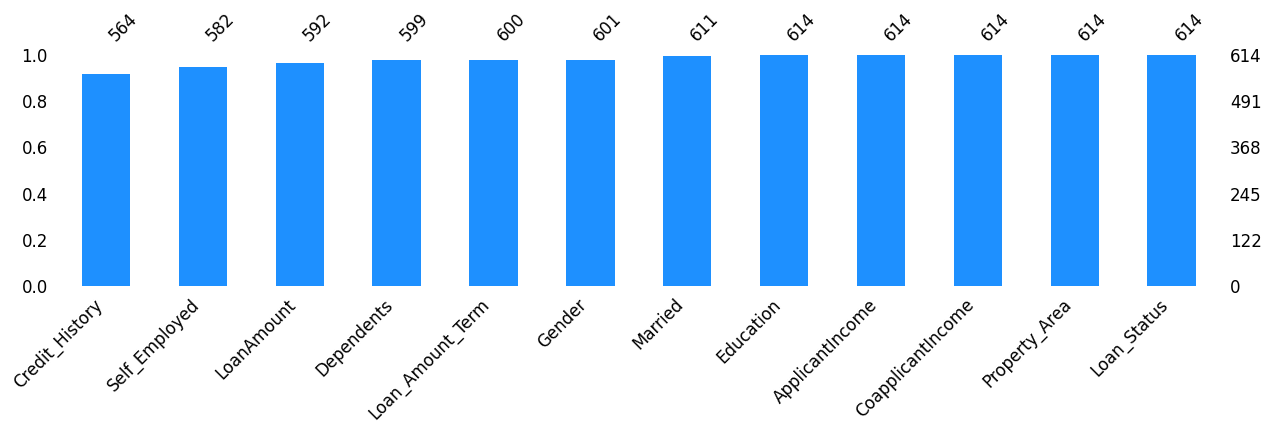

In [13]:
# Checking any missing values
print(df.isnull().mean()*100)

# Visualize missing values using a bar chart
msno.bar(df, figsize=(15, 3), color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

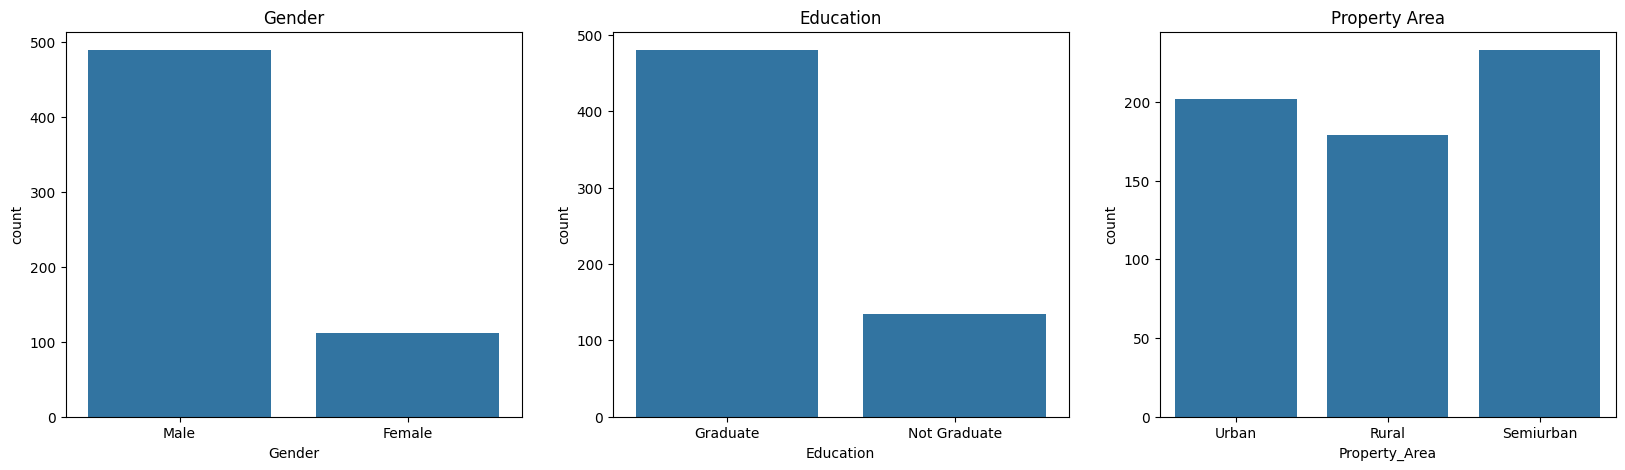

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(x='Gender', data=df, ax=ax[0])
ax[0].set_title('Gender')

sns.countplot(x='Education', data=df, ax=ax[1])
ax[1].set_title('Education')

sns.countplot(x='Property_Area', data=df, ax=ax[2])
ax[2].set_title('Property Area')

plt.show()

# Data Processing and Feature engineeering

In [15]:
# Creating a temporary copy of the dataframe
temp_df = df.copy()
temp_df.head(4)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1


In [16]:
# Storing all the features with less than 5% Missing values
Less_5PER_NaN = []
for cols in temp_df.columns:
    if (temp_df[cols].isnull().mean()*100) > 0 & (temp_df[cols].isnull().mean()*100 < 5):
        Less_5PER_NaN.append(cols)

Less_5PER_NaN

['Gender',
 'Married',
 'Dependents',
 'Self_Employed',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [19]:
# Univariate mean and mode imputation
for cols in Less_5PER_NaN:
    if (temp_df[cols].dtype == int) or (temp_df[cols].dtype == float):
        temp_df[cols] = temp_df[cols].fillna(temp_df[cols].median())
    else:
        temp_df[cols] = temp_df[cols].fillna(temp_df[cols].mode()[0])

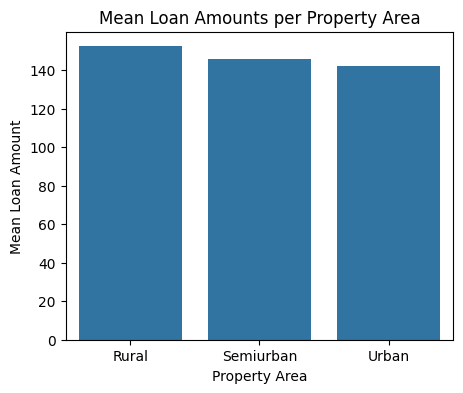

In [17]:
# Calculate mean loan amounts per property area
loan_per_area = df.groupby('Property_Area')['LoanAmount'].mean().reset_index()

# Plotting using sns.barplot
plt.figure(figsize=(5, 4))
sns.barplot(x='Property_Area', y='LoanAmount', data=loan_per_area)
plt.title('Mean Loan Amounts per Property Area')
plt.xlabel('Property Area')
plt.ylabel('Mean Loan Amount')
plt.show()

In [19]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))

# Plot KDE plots in the first column
sns.kdeplot(data=temp_df, x='ApplicantIncome', ax=ax[0, 0], fill=True)
sns.kdeplot(data=temp_df, x='CoapplicantIncome', ax=ax[1, 0], fill=True)
sns.kdeplot(data=temp_df, x='LoanAmount', ax=ax[2, 0], fill=True)

# Plot Q-Q plots in the second column
sm.qqplot(temp_df['ApplicantIncome'], line='45', ax=ax[0, 1], fit=True)
sm.qqplot(temp_df['CoapplicantIncome'], line='45', ax=ax[1, 1], fit=True)
sm.qqplot(temp_df['LoanAmount'], line='45', ax=ax[2, 1], fit=True)

# Plot box plots in the fourth column (corrected indices)
sns.boxplot(x='ApplicantIncome', data=temp_df, ax=ax[0, 2])
sns.boxplot(x='CoapplicantIncome', data=temp_df, ax=ax[1, 2])
sns.boxplot(x='LoanAmount', data=temp_df, ax=ax[2, 2])

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

### Outlier analysis
To deal with outliers there are couple of approaches which can be used out of which the most common ones are dropping the outliers or replacing the outliers with some other value like (Upper limit or Lower limit of that feature). But in both of the approaches there are some major drawbacks associated with them which are mentioned below

1. Dropping the outliers : By dropping the outliers the data will become more thin
2. Replacing values: By replacing the outliers with some other value the distribution will change significantly becasue of the less number of data points.
3. Mathematical transformation: In this approach we will simply transform the value of the attribute by using some mathematical function.

In [20]:
# Removing the extreme global outliers
temp_df = temp_df[temp_df['CoapplicantIncome']<10000]
temp_df = temp_df[temp_df['ApplicantIncome']<20000]
temp_df = temp_df[temp_df['LoanAmount']< 500]

In [21]:
# Calculate skewness before transformations
before_transformation = {
    'ApplicantIncome': skew(temp_df['ApplicantIncome']),
    'CoapplicantIncome': skew(temp_df['CoapplicantIncome']),
    'LoanAmount': skew(temp_df['LoanAmount']),
}


# Apply square root and cube root transformations
sqrt_transformation = {
    'ApplicantIncome': skew(np.sqrt(temp_df['ApplicantIncome'])),
    'CoapplicantIncome': skew(np.sqrt(temp_df['CoapplicantIncome'])),
    'LoanAmount': skew(np.sqrt(temp_df['LoanAmount'])),
}

cube_root_transformation = {
    'ApplicantIncome': skew(np.cbrt(temp_df['ApplicantIncome'])),
    'CoapplicantIncome': skew(np.cbrt(temp_df['CoapplicantIncome'])),
    'LoanAmount': skew(np.cbrt(temp_df['LoanAmount'])),
}

# Yeo-Johnson transformation (We have to find our lambda value prior)
yeojohn_transformation = {
    'ApplicantIncome': skew(yeojohnson(temp_df['ApplicantIncome'], yeojohnson(temp_df['ApplicantIncome'])[1])),
    'CoapplicantIncome': skew(yeojohnson(temp_df['CoapplicantIncome'],yeojohnson(temp_df['CoapplicantIncome'])[1])),
    'LoanAmount': skew(yeojohnson(temp_df['LoanAmount'], yeojohnson(temp_df['LoanAmount'])[1])),
}

# Create the DataFrame with all transformations
skew_df = pd.DataFrame({
    'Normal': before_transformation,
    'Sqrt': sqrt_transformation,
    'Cube Root': cube_root_transformation,
    'Yeo-Johnson': yeojohn_transformation,
})
skew_df

,Normal,Sqrt,Cube Root,Yeo-Johnson
ApplicantIncome,2.051701,1.174788,0.822722,0.029187
CoapplicantIncome,1.370090,0.226490,-0.027549,-0.187471
LoanAmount,1.667920,0.593340,0.214876,0.060518


We will be doing the square root transformation of both `CoapplicantIncome` and `LoanAmount` whereas for the `ApplicantIncome` feature we will be doing the cube root transformation

In [22]:
# Ordinal encoding the features
Education_encode = OrdinalEncoder(categories=[['Graduate', 'Not Graduate']], handle_unknown="use_encoded_value", unknown_value=np.nan)
Self_Employed_encode = OrdinalEncoder(categories=[['No', 'Yes']], handle_unknown="use_encoded_value", unknown_value=np.nan)
Dependents_encode = OrdinalEncoder(categories=[['0', '1', '2', '3+']], handle_unknown="use_encoded_value", unknown_value=np.nan)
Loan_Amount_Term_encode = OrdinalEncoder(categories=[[12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0]], handle_unknown="use_encoded_value", unknown_value=np.nan)

temp_df['Education'] = Education_encode.fit_transform(temp_df['Education'].values.reshape(-1, 1)).reshape(-1)
temp_df['Self_Employed'] = Self_Employed_encode.fit_transform(temp_df['Self_Employed'].values.reshape(-1, 1)).reshape(-1)
temp_df['Dependents'] = Dependents_encode.fit_transform(temp_df['Dependents'].values.reshape(-1, 1)).reshape(-1)
temp_df['Loan_Amount_Term'] = Loan_Amount_Term_encode.fit_transform(temp_df['Loan_Amount_Term'].values.reshape(-1, 1)).reshape(-1)

In [23]:
# One-hot encoding
gender_encoded = pd.get_dummies(temp_df['Gender'], prefix='Gender').astype(int)
married_encoded = pd.get_dummies(temp_df['Married'], prefix='Married').astype(int)
property_area_encoded = pd.get_dummies(temp_df['Property_Area'], prefix='Property_Area').astype(int)

In [24]:
# Concatenate the one-hot encoded DataFrames
temp_df = pd.concat([temp_df, gender_encoded, married_encoded, property_area_encoded], axis=1)

# Drop the original categorical columns
temp_df = temp_df.drop(['Gender', 'Married', 'Property_Area'], axis=1)

### Correlation analysis

If the features in a regression model are not highly correlated, it generally eliminates the concerns related to multicollinearity. In fact, low correlation between features is often preferred in regression modeling. Here are some reasons why low correlation between features is beneficial:

1. Improved Interpretability: When features are not highly correlated, it is easier to interpret the individual impact of each variable on the target variable. The coefficients in the regression equation represent the change in the target variable for a one-unit change in the corresponding predictor, holding other predictors constant.

2. Stable Coefficients: With low correlation, the coefficients of the individual predictors tend to be more stable and less sensitive to changes in the dataset. This stability enhances the reliability of the model.

3. Reduced Redundancy: Low correlation indicates that the information provided by each feature is relatively unique. Redundant information can lead to overfitting and does not contribute significantly to the predictive power of the model.

4. Feature Importance: In models like linear regression, low correlation helps in identifying the most important features, as the coefficients are less likely to be influenced by collinearity.

5. Efficient Model Training: Low correlation between features can also improve the efficiency of model training, as the model doesn't have to navigate through highly correlated feature spaces.

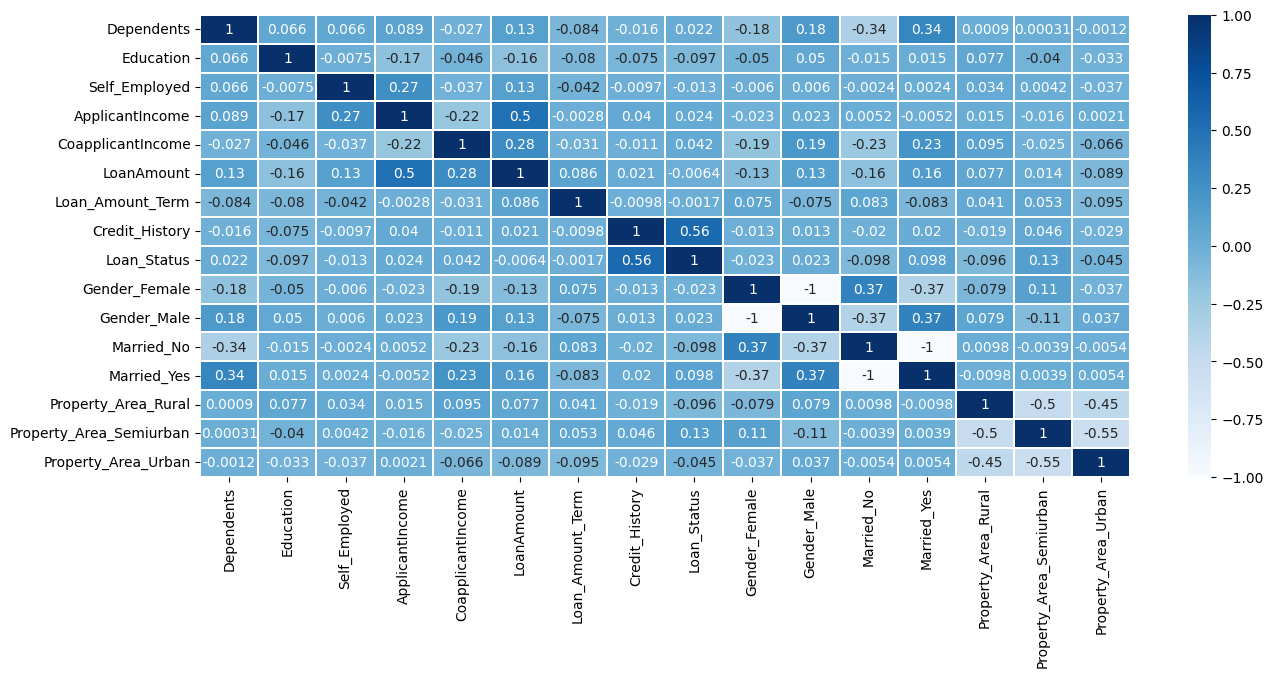

In [28]:
plt.figure(figsize=(15, 6))
sns.heatmap(temp_df.corr(), annot=True,cmap="Blues",linewidths = 0.1)
plt.show()

In [26]:
# Removing the features to deal with the problem of multi-collinearity
temp_df.drop(['Gender_Female','Married_No'],axis=1,inplace=True)

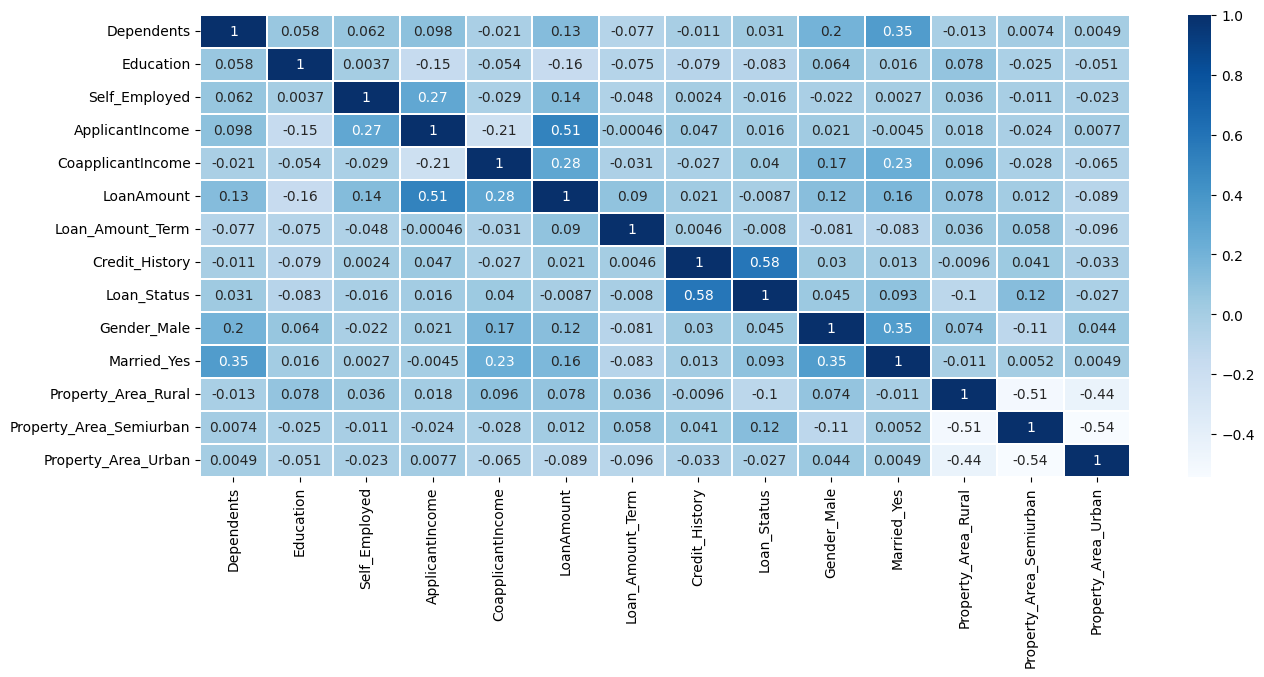

In [27]:
plt.figure(figsize=(15, 6))
sns.heatmap(temp_df.corr(), annot=True,cmap="Blues",linewidths = 0.1)
plt.show()

# Dealing with missing values

In [28]:
# Removing the extreme global outliers
df = df[df['CoapplicantIncome']<10000]
df = df[df['ApplicantIncome']<20000]
df = df[df['LoanAmount']< 500]

In [29]:
# Univariate mean and mode imputation
for cols in Less_5PER_NaN:
    if (df[cols].dtype == int) or (df[cols].dtype == float):
        df[cols] = df[cols].fillna(df[cols].median())
    else:
        df[cols] = df[cols].fillna(df[cols].mode()[0])

C:\Users\ropar_i9941t3\AppData\Local\Temp\ipykernel_10064\1345593782.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cols] = df[cols].fillna(df[cols].mode()[0])


In [30]:
new_order = ['Education', 'Self_Employed','Dependents','Loan_Amount_Term','Gender', 'Married', 'Property_Area',
             'CoapplicantIncome', 'LoanAmount','ApplicantIncome', 'Credit_History', 'Loan_Status']
df = df.reindex(columns=new_order)

In [31]:
df.head(4)

,Education,Self_Employed,Dependents,Loan_Amount_Term,Gender,Married,Property_Area,CoapplicantIncome,LoanAmount,ApplicantIncome,Credit_History,Loan_Status
1,Graduate,No,1,360.0,Male,Yes,Rural,1508.0,128.0,4583,1.0,0
2,Graduate,Yes,0,360.0,Male,Yes,Urban,0.0,66.0,3000,1.0,1
3,Not Graduate,No,0,360.0,Male,Yes,Urban,2358.0,120.0,2583,1.0,1
4,Graduate,No,0,360.0,Male,No,Urban,0.0,141.0,6000,1.0,1


# Data processing pipeline

To make the complete process streamlit it is very much important to make sure that we are building a pipeline that will be reponsible for processing the data and in our case for processing the data there will be 3 differen components and these are

1. Categorical feature encoding: In this we will be encoding the categorical attribute like ordinal encoding and one hot encoding so that it becomes easy for the algorithms to understand what information is captured in the categorical attribute. The encoding in our case will be of 3 different types that is ordinal encoding, one hot encoding and target encoding.


In [32]:
# Column transformer for doing ordinal and nominal encoding
encoding_transformer = ColumnTransformer(transformers=[

    # Ordinal encoding
    ('Encode_Edu', OrdinalEncoder(categories=[['Not Graduate','Graduate']], handle_unknown="use_encoded_value", unknown_value=np.nan), [0]),
    ('Encode_SEmp', OrdinalEncoder(categories=[['No', 'Yes']], handle_unknown="use_encoded_value", unknown_value=np.nan), [1]),
    ('Encode_Depen', OrdinalEncoder(categories=[['0', '1', '2', '3+']], handle_unknown="use_encoded_value", unknown_value=np.nan), [2]),
    ('Encode_Loan_Amount_term', OrdinalEncoder(categories=[[12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0]], handle_unknown="use_encoded_value", unknown_value=np.nan), [3]),

    # One hot encoding
    ('Encode_Gender', OneHotEncoder(handle_unknown='ignore', drop='first'), [4]),
    ('Encode_Married', OneHotEncoder(handle_unknown='ignore', drop='first'), [5]),
    ('Encode_Property_Area', OrdinalEncoder(categories=[['Rural','Semiurban','Urban']], handle_unknown="use_encoded_value", unknown_value=np.nan), [6]),
], remainder='passthrough')


# Column transformer for mathematical transformation CoapplicantIncome, loan amount
math_transformer = ColumnTransformer(transformers=[
    ('log_CoApplication', FunctionTransformer(func = np.log1p), [7]),
    ('log_loan_amt', FunctionTransformer(func = np.log1p), [8]),
    ('log_ApplicantIncome', FunctionTransformer(func = np.cbrt), [9]),
], remainder='passthrough')


# Column transformer for doing feature scaling
scaling_transformer = ColumnTransformer(transformers=[
    ('MinMaxScaling', MinMaxScaler(copy=False), [0, 1, 2]),
], remainder='passthrough')


# Stacking column transformers to create a Processing pipeline
Processing_pipeline = Pipeline(steps=[
    ('Encoding', encoding_transformer),
    ('Transformation', math_transformer),
    ('Scaling', scaling_transformer),
], memory='Temp')

In [33]:
# Transforming the data
X = df.drop(['Loan_Status'],axis=1)
y = df['Loan_Status']

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = 1)

In [43]:
# Copying the dataframe for finding the feature importance scores
Feature_selection_df = X_train.copy()

# Reseting the dataframe
Feature_selection_df.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

# Adding the target variable
Feature_selection_df['Loan_status'] = y_train

Run the code below to get the trained classification pipeline

In [36]:
# X_train = Processing_pipeline.fit_transform(X_train,y_train)
# X_test = Processing_pipeline.transform(X_test)

# Save the pipeline to a file using pickle
with open('Classification_pipeline.pkl', 'wb') as f:
    pickle.dump(Processing_pipeline, f)

# Feature Selection

After doing one hot encoding of the Gender feature we will have features = (Number of unique values in gender feature), similarly for the other features as well there will be some dummy features that will be excessive so we need to make sure that the less related features are removed

In [ ]:
# Copying the dataframe
Feature_selection_df = X_train.copy()

# Reseting the dataframe
Feature_selection_df.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

# Adding the target variable
Feature_selection_df['Loan_status'] = y_train

### Technique 1 : Random forest classifier

In [ ]:
# Rf_Model = RandomForestClassifier(n_estimators=100, random_state=42)
# Rf_Model.fit(Feature_selection_df, y_train)

# Rf_Model_FI_df = pd.DataFrame({'Features': Feature_selection_df.columns,'RF_Importance': Rf_Model.feature_importances_})
# Rf_Model_FI_df.sort_values(by='RF_Importance', inplace=True, ascending=False)
# Rf_Model_FI_df

# Model performance Comparision

In [54]:
def scorer(model_name, model):
    """
    This function takes a model name as input and injects that model into the training pipeline to process
    and train the model using the training data. After that, this function uses K-fold cross-validation technique
    to calculate the average accuracy score.

    Parameters:
    - model_name (str): Name of the model.
    - model: The machine learning model to be trained and evaluated.

    Returns:
    List: A list containing the model name and its average accuracy score.
    """

    output = []
    output.append(model_name)

    # Stacking column transformers to create a Training pipeline
    Training_pipeline = Pipeline(steps=[
    ('Encoding', encoding_transformer),
    ('Transformation', math_transformer),
    ('Scaling', scaling_transformer),
    ('Classifier',model)
    ], memory='Temp')

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(Training_pipeline, X_train, y_train, cv=kfold, scoring='accuracy')

    output.append(scores.mean())

    # Training the model and getting predictions
    Training_pipeline.fit(X_train, y_train)
    y_pred = Training_pipeline.predict(X_test)

    # Using accuracy_score for classification
    accuracy = f1_score(y_test, y_pred)
    output.append(accuracy)

    return output

In [55]:
# Dictionary of classification models
classification_model_dict = {
    'logistic_regression': LogisticRegression(),
    'naive_bayes': GaussianNB(),
    'support_vector_machine': SVC(),
    'k_neighbors': KNeighborsClassifier(),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'extra_trees': ExtraTreesClassifier(),
    'gradient_boosting': GradientBoostingClassifier(),
    'adaboost': AdaBoostClassifier(),
    'xgboost': XGBClassifier()
}

In [ ]:
model_output = []
for model_name,model in classification_model_dict.items():
    model_output.append(scorer(model_name, model))

In [57]:
model_df = pd.DataFrame(model_output, columns=['name','accuracy','f1_score'])
model_df.sort_values(['f1_score'])

,name,accuracy,f1_score
4,decision_tree,0.682609,0.840237
6,extra_trees,0.763430,0.873563
3,k_neighbors,0.767923,0.885246
9,xgboost,0.763478,0.901734
7,gradient_boosting,0.772271,0.902174
8,adaboost,0.756908,0.903226
5,random_forest,0.782995,0.911111
0,logistic_regression,0.811546,0.918919
1,naive_bayes,0.807198,0.918919
2,support_vector_machine,0.811546,0.918919


# Model training

In [ ]:
X_train

In [34]:
X_train = Processing_pipeline.fit_transform(X_train,y_train)
X_test = Processing_pipeline.transform(X_test)

In [60]:
def objective(trial):

    # Define hyperparameters to be optimized
    C = trial.suggest_float('C', 1e-5, 1e5)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

    # Create an SVC with the suggested hyperparameters
    model = SVC(C=C, kernel=kernel)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate f1_score as the objective to be optimized
    f1 = f1_score(y_test, y_pred)

    return f1

In [61]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')  # 'maximize' for f1 score
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-02-27 06:08:08,382] A new study created in memory with name: no-name-c6bb6b4c-f983-4c2b-9fb4-df4a50ea4391
[I 2024-02-27 06:08:09,289] Trial 0 finished with value: 0.8165680473372781 and parameters: {'C': 66784.7511092515, 'kernel': 'rbf'}. Best is trial 0 with value: 0.8165680473372781.
[I 2024-02-27 06:08:10,329] Trial 1 finished with value: 0.8165680473372781 and parameters: {'C': 63255.51617273387, 'kernel': 'rbf'}. Best is trial 0 with value: 0.8165680473372781.
[I 2024-02-27 06:08:18,632] Trial 2 finished with value: 0.8409090909090909 and parameters: {'C': 71059.06320036271, 'kernel': 'poly'}. Best is trial 2 with value: 0.8409090909090909.
[I 2024-02-27 06:08:18,654] Trial 3 finished with value: 0.7672955974842768 and parameters: {'C': 21811.762920107492, 'kernel': 'sigmoid'}. Best is trial 2 with value: 0.8409090909090909.
[I 2024-02-27 06:08:32,676] Trial 4 finished with value: 0.9189189189189189 and parameters: {'C': 43271.47300214036, 'kernel': 'linear'}. Best is tri

Best Hyperparameters: {'C': 43271.47300214036, 'kernel': 'linear'}


In [62]:
# Defining the best model
best_model = SVC(**best_params)

# Trainig the model
best_model.fit(X_train, y_train)

SVC(C=43271.47300214036, kernel='linear')

# Logistic regression training for inference

In [ ]:
logistic_model = LogisticRegression()

# Training the model
logistic_model.fit(X_train,y_train)

In [64]:
columns = ['CoapplicantIncome', 'LoanAmount', 'ApplicantIncome', 'Education', 'Self_Employed', 'Dependents',
           'Loan_Amount_Term', 'Gender', 'Married', 'Property_Area', 'Credit_History']

# Coefficient values
coeff_values = logistic_model.coef_[0]

# Creating a Pandas Series
coefficients_series = pd.Series(coeff_values, index=columns)
coefficients_series.sort_values(inplace=True)
coefficients_series

LoanAmount          -0.741472
Gender              -0.258189
Self_Employed       -0.039037
Loan_Amount_Term     0.001869
Dependents           0.031101
Property_Area        0.139797
ApplicantIncome      0.271915
CoapplicantIncome    0.335169
Education            0.350325
Married              0.456099
Credit_History       3.178946
dtype: float64

In [65]:
# Save the pipeline to a file using pickle
with open('Classification_Coeff.pkl', 'wb') as f:
    pickle.dump(coefficients_series, f)

In [66]:
# Creating a color heatmap using Plotly Express
fig = px.imshow(coefficients_series.to_frame().T, color_continuous_scale='greens')

# Adding axis labels
fig.update_layout(
    xaxis=dict(title='Features'),
    yaxis=dict(title='Coefficient Values')
)

# Displaying the interactive heatmap
fig.show()

# Model evaluation

In [67]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Display classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

Accuracy: 0.8696
Confusion Matrix:
[[15 15]
 [ 0 85]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        30
           1       0.85      1.00      0.92        85

    accuracy                           0.87       115
   macro avg       0.93      0.75      0.79       115
weighted avg       0.89      0.87      0.85       115



# Saving Model,Pipeline and coefficient series

In [ ]:
# Save the trained KNeighborsClassifier to a file using pickle
with open('../Trained_Model/SVC.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [ ]:
# Save the data to a file using pickle
with open('../Model Building/Loan_Pipeline.pkl', 'wb') as file:
    pickle.dump(Processing_pipeline, file)

In [ ]:
# Save the trained KNeighborsClassifier to a file using pickle
with open('../Trained_Model/Coeff_series.pkl', 'wb') as file:
    pickle.dump(coefficients_series, file)